In [1]:
from typing import Callable, List

import pickle

import numpy as np
import numpy.random

from scipy.integrate import solve_ivp, odeint
from scipy.linalg import inv
_

import matplotlib as mpl

import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from notebook.services.config import ConfigManager
from traitlets.config.manager import BaseJSONConfigManager


# set jupyter configurations
%matplotlib inline
%config InlineBackend.figure_format='retina'
default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = default_dpi*1.2  

STYLE_MORTAR = dict(xlim=(0,350), ylim=(0,150), xlabel='distance traveled (m)', ylabel='height (m)')
start_bold, end_bold = '\033[1m', '\033[0m'

import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_compare(d_o, x_o, d, x, color_1='grey', color_2='red', 
             style=STYLE_MORTAR, grid=True, legend=True, ax=None):
    """Return axis comparing simulation output to observations. Show obs. error.
    
    Creates axis if not passed."""
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(d_o, x_o, label='$x_\mathrm{o}$', marker='o', color=color_1, s=10)
    ax.scatter(d, x, label='x', marker='x', color=color_2, s=10)
    
    style['title'] = f"MSE: {np.square(np.subtract(x_o, x)).mean():.2f}"
        
    plt.setp(ax, **style)
    if legend:
        ax.legend()
    ax.grid(True)
    
    return ax

In [3]:
def interactive_projectile(simulator, filename_obs:str="mortar-x_o-1.pickle"):
    """ Return interactive plot for the projectile simulation using a wrapper."""
    
    #load ground truth
    with open(filename_obs, "rb") as f:
        d_o, x_o = pickle.load(f)
                
    def visualize_projectile(speed, angle, drag):
        """Simulate using args from interactive and display the results."""
        
        sim = simulator(speed, angle, drag)        
        
        ax = plot_compare(d_o, x_o, sim['d'], sim['x'])
        plt.show()
       
        return dict(θ=(speed, angle, drag), d=sim['d'], h=sim['x'], x=sim['x'])
    
    return interactive(visualize_projectile, speed=(50,250), angle=(10,45), drag=(0.01,0.7,0.01))


### 1.4.1 Ballistic motion problem
- projectile is launched with given launch velocity, launch angle, and a drag coefficient
- we can measure height of projectile with certain imprecision

In [4]:
def mortar_core(speed: float, angle:int, drag:float, 
           r:float=0.050, m:float=0.2, h_noise:float=3., ρ:float=1.225, g:float=9.81)->np.array:
    
    k = 0.5 * drag * ρ * (np.pi*r**2) # drag constant, proportional to area

    def deriv(t, u):
        """Return right-hand side of ODE system for the mortar."""
        # see diagram at e.g. http://www.physics.smu.edu/fattarus/ballistic.html
        x, v_x, z, v_z = u
        speed = np.hypot(v_x, v_z)
        a_x, a_z = -k/m * speed * v_x, -k/m * speed * v_z - g
        
        return v_x, a_x, v_z, a_z

    
    # position and velocity components at launch
    x0, z0 = 0, 0
    rad_angle = np.radians(angle) 
    v0_x, v0_z =  speed*np.cos(rad_angle), speed*np.sin(rad_angle)
    
    # integration grid
    t = np.linspace(0, 400, 4000)
    
    # solve initial value problem (ivp) for distance traveled(t) and height(t)
    # df/dt = f(t,y); f(t_i) = y_i, 
    solution = solve_ivp(deriv, t_span=(t[0], t[-1]), y0=(x0, v0_x, z0, v0_z), 
                        dense_output=True) # dense => continuous solution
    
    # evaluate solution to obtain distance and height at each time point
    d, _, h , _ = solution.sol(t)
    
    x = h + h_noise*np.random.randn(d.shape[0])
    return x

In [5]:
def mortar(speed: float, angle:int, drag:float, 
           r:float=0.050, m:float=0.2, h_noise:float=3., ρ:float=1.225, g:float=9.81)->dict:
    """ Simulate the firing of a projectile.
    Args:
        speed: magnitude of initial speed (m/s).
        angle: launch angle with horizontal (degrees)
        drag: drag coefficient
        r: projectile radius (m)
        m: projectile mass (kg)
        h_noise: std of measurements of altitude (m)
        ρ: air density (default is at sea surface, 15C)
        g: gravitational acceleration (default is average at surface of Earth)
    Returns:
        simulation (dict): simulation results containing distance travelled 
                           and height as a function of time.   
    
    Following https://scipython.com/book2/chapter-8-scipy/examples/a-projectile-with-air-resistance/
    """

    k = 0.5 * drag * ρ * (np.pi*r**2) # drag constant, proportional to area
    
    def deriv(t, u):
        """Return right-hand side of ODE system for the mortar."""
        # see diagram at e.g. http://www.physics.smu.edu/fattarus/ballistic.html
        x, v_x, z, v_z = u
        speed = np.hypot(v_x, v_z)
        a_x, a_z = -k/m * speed * v_x, -k/m * speed * v_z - g
        
        return v_x, a_x, v_z, a_z

    
    # position and velocity components at launch
    x0, z0 = 0, 0
    rad_angle = np.radians(angle) 
    v0_x, v0_z =  speed*np.cos(rad_angle), speed*np.sin(rad_angle)
    
    # integration grid
    t = np.linspace(0, 400, 4000)
    
    # solve initial value problem (ivp) for distance traveled(t) and height(t)
    # df/dt = f(t,y); f(t_i) = y_i, 
    solution = solve_ivp(deriv, t_span=(t[0], t[-1]), y0=(x0, v0_x, z0, v0_z), 
                        dense_output=True) # dense => continuous solution
    
    # evaluate solution to obtain distance and height at each time point
    d, _, h , _ = solution.sol(t)
    
    x = h + h_noise*np.random.randn(d.shape[0])
    
    # to obtain the params from the interactive plot, we need to return parameters here as well
    return dict(θ=(speed, angle, drag, r, m, h_noise, ρ, g), d=d, x=x)

In [6]:
# THIS IS HOW WE GENERATED THE EXPERIMENTAL OBSERVATION
#
# θ_true_1 = () # this is secret
# sim_o = mortar(*θ_true_1, h_noise=0)
# d_o, x_o = sim_o['d'], sim_o['x']
# with open("mortar-x_o-1.pickle", "wb") as f:
#     pickle.dump((d_o, x_o), f)

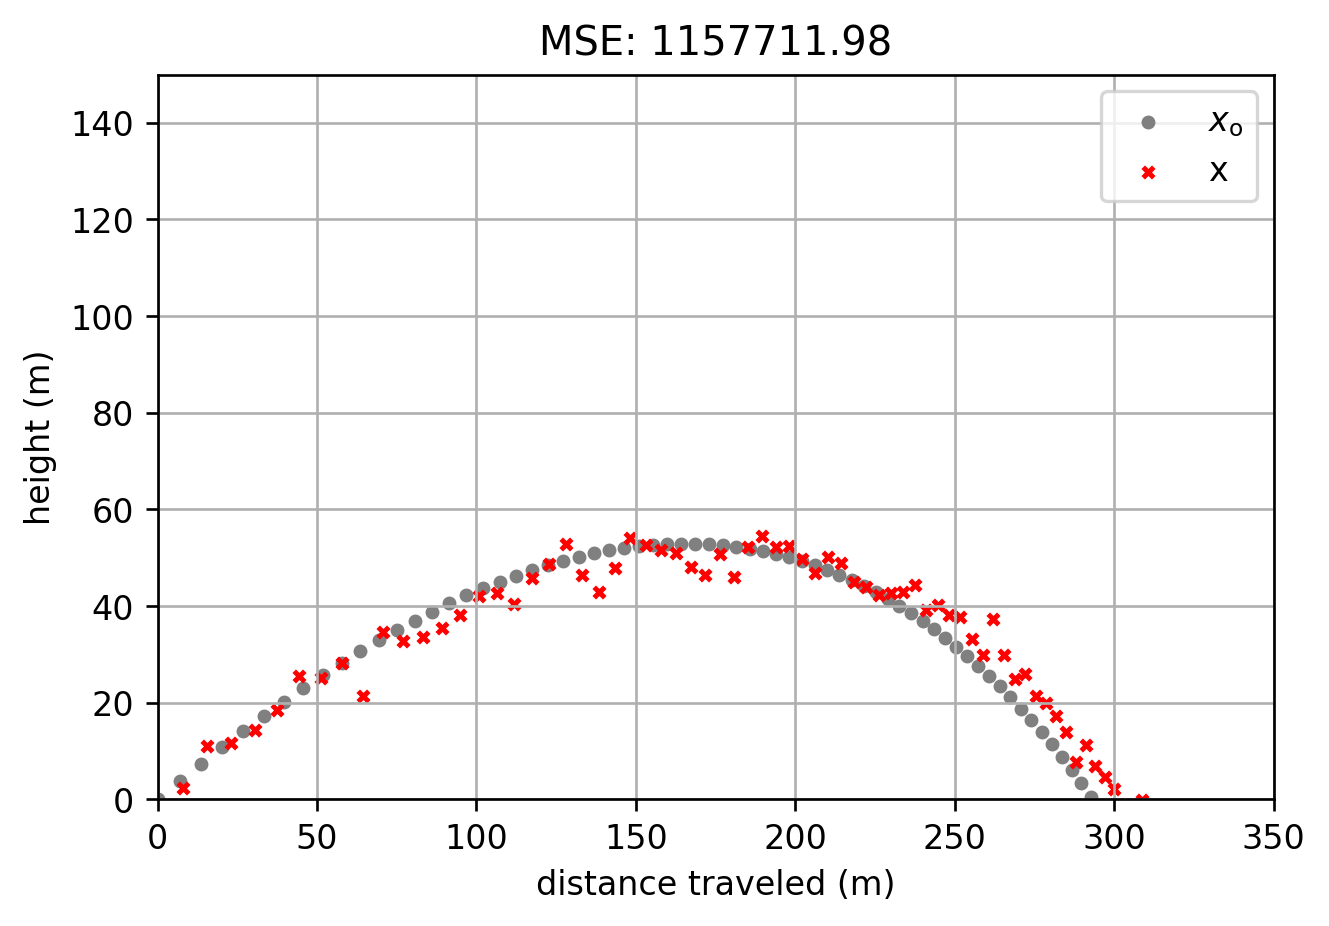

In [7]:
# SCROLL DOWN FOR AN INTERACTIVE VERSION

# load experimental observation
with open("mortar-x_o-1.pickle", "rb") as f:
    d_o, x_o = pickle.load(f)
    
sim = mortar(90, 27, 0.13)
d, x = sim['d'], sim['x']
plot_compare(d_o, x_o, d, x);

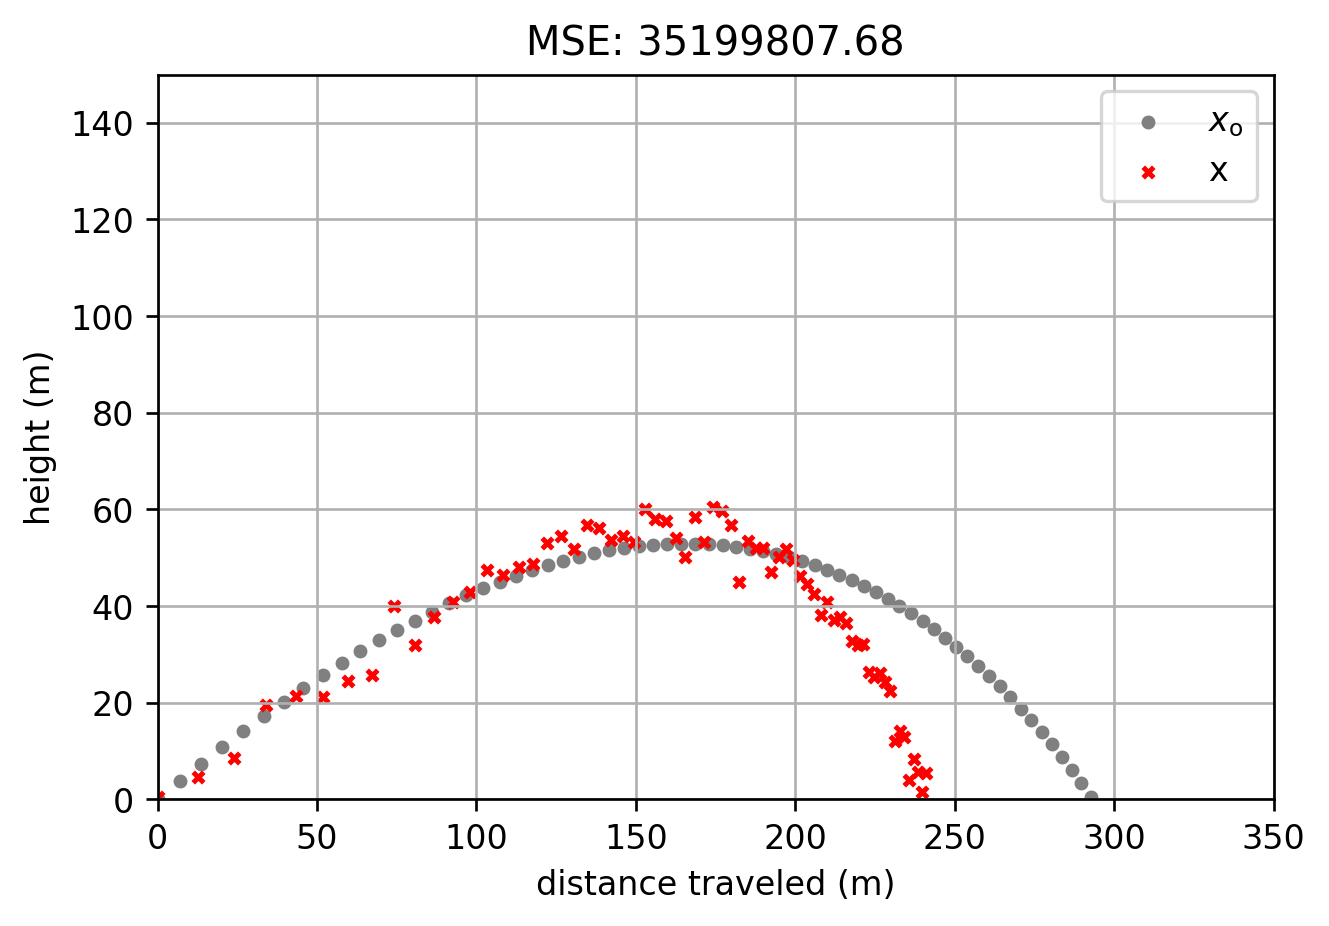

In [8]:
# FANCIER COMPARISON - try to get error < 200
interactive_projectile(mortar)

### 1.4.2 Linear regression as baseline
- how can we find the underlying parameters of the observation?
- with linear regression on quadratic polynomial parameters? 

In [9]:
def linear_regression(X:np.array, y:np.array)-> np.array:
    """ Perform linear regression y = β X + ϵ
    
    Args:
        X: features (independent variable)
        y: dependent variable
        
    Returns:
        Parameters of linear regression.
        
    """
    β = inv(X.T @ X) @ (X.T @ y)
    
    return β


sim_o = mortar(60, 29, 0.00000001) # no drag
d_o, x_o = sim_o['d'], sim_o['x']
d_o_features = np.stack([np.ones_like(d_o), d_o**1, d_o**2]).T
β = linear_regression(d_o_features, x_o)

# generate reconstruction with found parameters
linreg_altitudes = d_o_features @ β

<AxesSubplot:title={'center':'MSE: 12.05'}, xlabel='distance traveled (m)', ylabel='height (m)'>

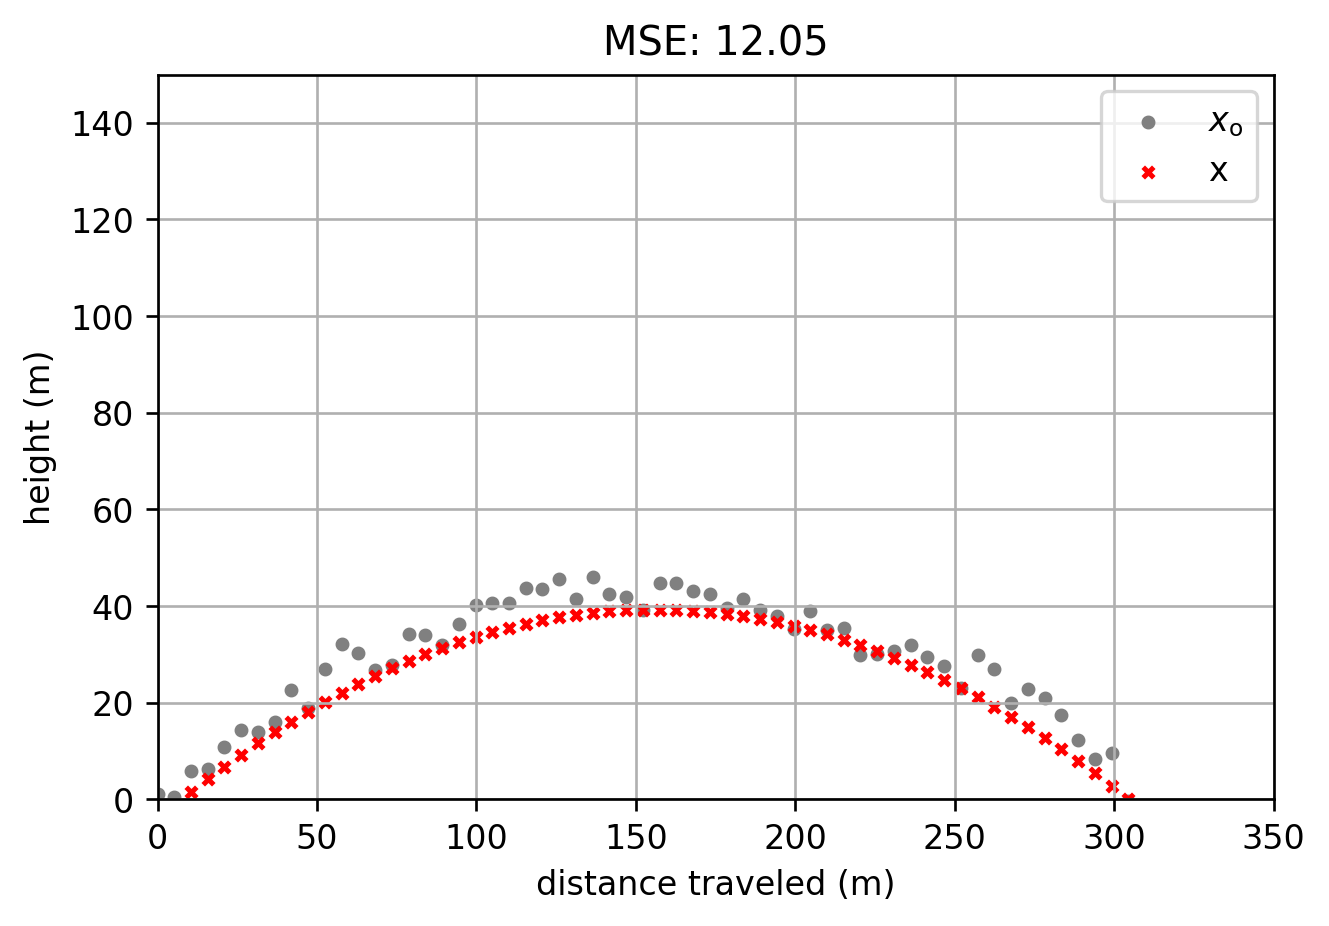

In [10]:
plot_compare(d_o, x_o, d_o, linreg_altitudes)

### 1.4.3 Try to reproduce data manually 🛠️
- assuming you can build a forward model
- can you beat the linear regression model?

Simulation with parameters launch speed=98.5, angle=37.4, and drag=0.47
had error:  12638863.40
Based on chosen ε=25000, the simulation was     not accepted


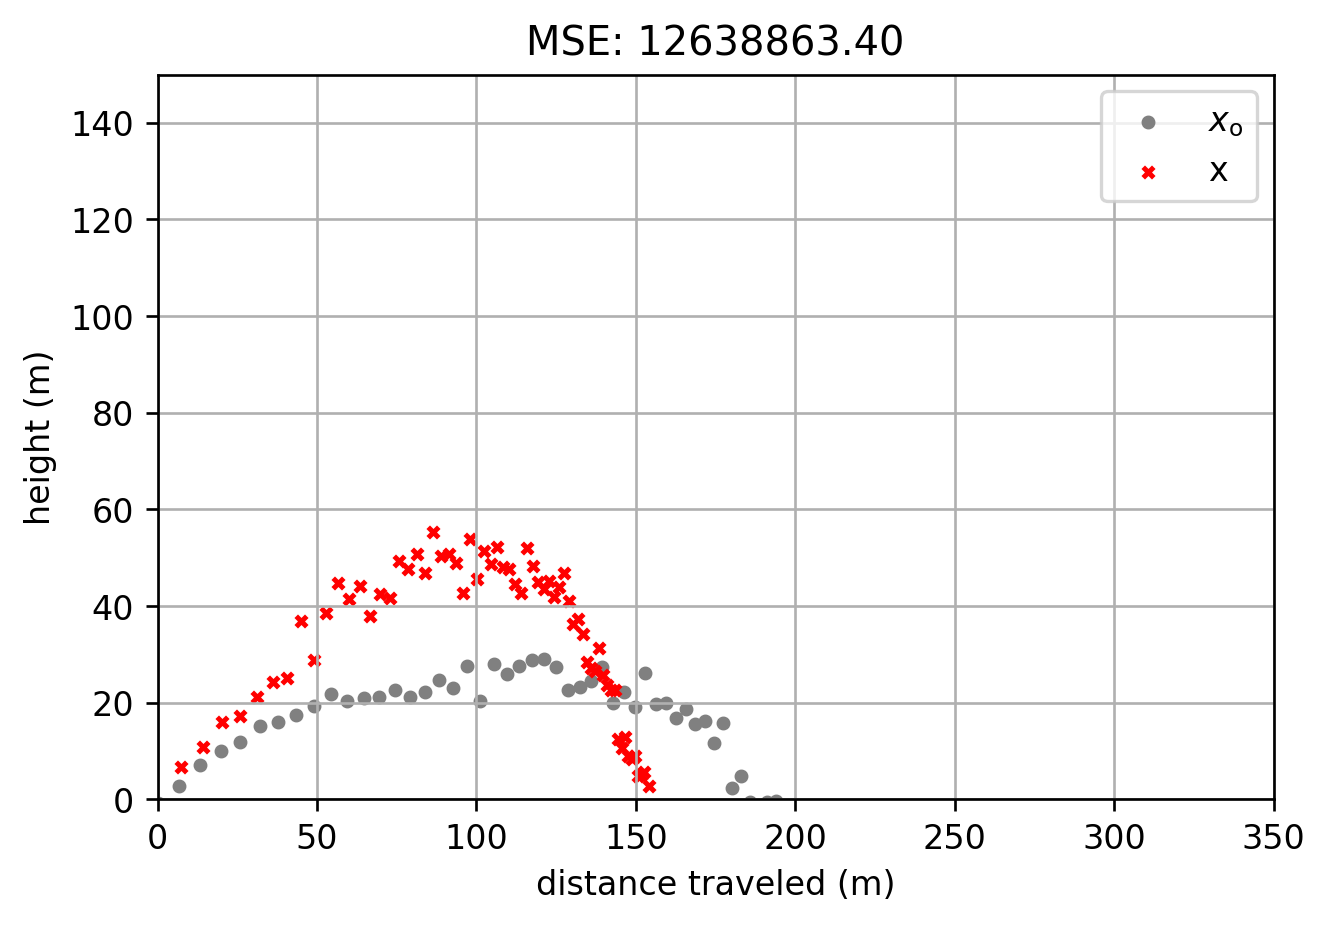

In [11]:
# XXX to basic functions
def distance(x1:np.array, x2:np.array, d_func:Callable) -> float:
    """ Returns distance according to specified distance measure.
    Args:
        x1, x2 
        d_func: distance function (symmetric)
    Returns:
        distance between prediction and data.
    """
    def ensure_array(x):
        try:
            len(x)
        except AttributeError:
            x = np.array([x])         
        
        return x

    x1, x2 = map(ensure_array, [x1, x2])
    assert len(x1) == len(x2)
    
    return d_func(x1, x2)

# choose a distance function ...
mse = lambda x1, x2: np.square(np.subtract(x1, x2)).mean()
chebyshev = lambda x1, x2: np.max(np.abs(np.subtract(x1,x2)))


def random_simulation():
    """Return simulation results from uniformly sampled parameters."""
    U = np.random.uniform

    speed = U(20, 150)
    angle = U(10, 45)
    drag = U(0.05, 0.5)
    
    simulation = mortar(speed, angle, drag)
    
    return simulation['d'], simulation['x'], simulation['θ']


# some reference data with known parameters
sim_o = mortar(75, 22, 0.2)
d_o, x_o = sim_o['d'], sim_o['x']


d, x, θ = random_simulation()

style_cheby = {**STYLE_MORTAR, **dict(title=f"Chebyshev {chebyshev(x_o,x):.2f}")}
plot_compare(d_o, x_o, d, x);

error = mse(x,x_o)#distance(x, x_o, mse)

# ... and an acceptance threshold ε ...
ε = 25000

# ...to decide about acceptance
accepted = error < ε

#print(f"Simulation with parameters {sim['θ']}  )


print(f'Simulation with parameters launch speed={θ[0]:.1f}, \
angle={θ[1]:.1f}, and drag={θ[2]:.2f}\nhad error: {start_bold} {error:.2f}{end_bold}')
print(
    f'Based on chosen {start_bold}ε={ε}{end_bold}, the simulation was {start_bold}\
    {"accepted" if accepted else "not accepted"}{end_bold}')

### 1.4.4 Automate the search for parameters 🛠️
- there should be a smarter way to approach this
- your task is now to automate what we just tried manually and make decisions which paramters to keep, based on distance

In [12]:
def rejection_abc(distance_function:Callable, ε:float, x_o, n_samples=100)-> (List, int):
    """Return list of parameters such that distance of simulation x to x_o is <= ε.
    
    
    Args:
        ε: acceptance threshold
        distance_function: function to compute distance between prediction and observation
        n_samples: desired number of accepted parameter samples
                   (aalternatively, you can cap the number of simulations and check how many
                    acceptances you get*)
    Return:
        θ_accepted (list) : list of tuples with accepted parameters
        sim_no (int) : number of simulations that were needed
        
    """
    θ_accepted = []
    sim_no = 0
    U = np.random.uniform
    while len(θ_accepted) < n_samples:
        
        d, x, θ = random_simulation()
        error = distance_function(x,x_o)
        if error < ε:
            θ_accepted.append(θ)
        sim_no +=1
       
    return θ_accepted, sim_no

In [13]:
# get us some mysterious observations
with open("mortar-x_o-1.pickle", "rb") as f:
    d_o, x_o = pickle.load(f)
    
ϵ = 10000
θ_accepted, sim_no = rejection_abc(mse, ϵ, x_o, n_samples=10)
print(f'Your rejection-ABC implementation has found {len(θ_accepted)}\
 parameters \nthat produce observations within ε={ε} using {sim_no} simulations.')

Your rejection-ABC implementation has found 10 parameters 
that produce observations within ε=10000 using 1300 simulations.


Distance of simulation with automatically found parameters
launch velocity=81.5,launch angle=26.2, and drag coefficient=0.11: 163.12


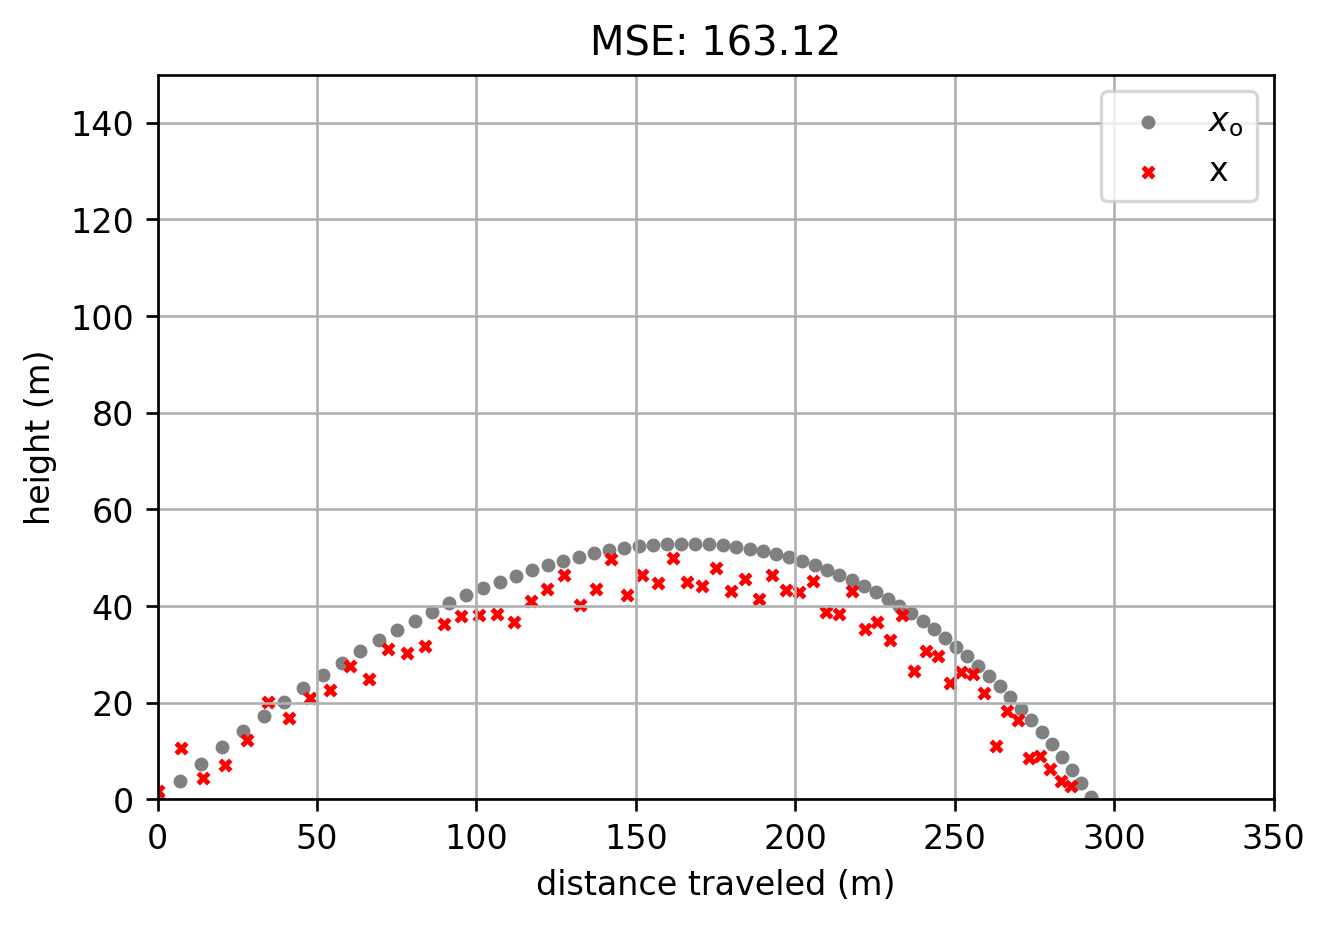

In [14]:
# plot with one of the found parameters
# speed, angle, drag = θ_accepted[np.random.randint(len(θ_accepted))]
# ... or better, with the mean
# try plotting means with increasingly more samples (you can save across executions)

speed, angle, drag = list(np.mean(np.array(θ_accepted)[:, 0:3], axis=0))
sim_chosen = mortar(speed, angle, drag)
d, x = sim_chosen['d'], sim_chosen['x']
error = distance(x, x_o, mse)

plot_compare(d_o, x_o, d, x)

print(f'Distance of simulation with automatically found parameters\nlaunch velocity={speed:.1f},\
launch angle={angle:.1f}, and drag coefficient={drag:.2f}: {start_bold}{error:.2f}{end_bold}')

- You just discovered rejection ABC!
- Reflect on how choice of $\epsilon$, $d$ was made
- How much extra computation is needed if the observation $x_o$ changes?

### 1.4.7 Introduce SBI as a potentially useful approach to solve our problem

In [15]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import torch.nn as nn

In [16]:
def sbi_mortar(θ):
    """Wrapper for mortar function to work with SBI."""
    speed, angle, damp = θ
    return mortar_core(speed, angle, damp)

        
# define the same prior as above with U(low, high), a box in 3 dimensions
prior = utils.BoxUniform(low=torch.Tensor([50,15,0.01]), high=torch.Tensor([100,40,0.5]))

# ... and infer the posterior over θ using the sbi toolkit
posterior = infer(sbi_mortar, prior, method='SNPE', num_simulations=1000, num_workers=4)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Neural network successfully converged after 81 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

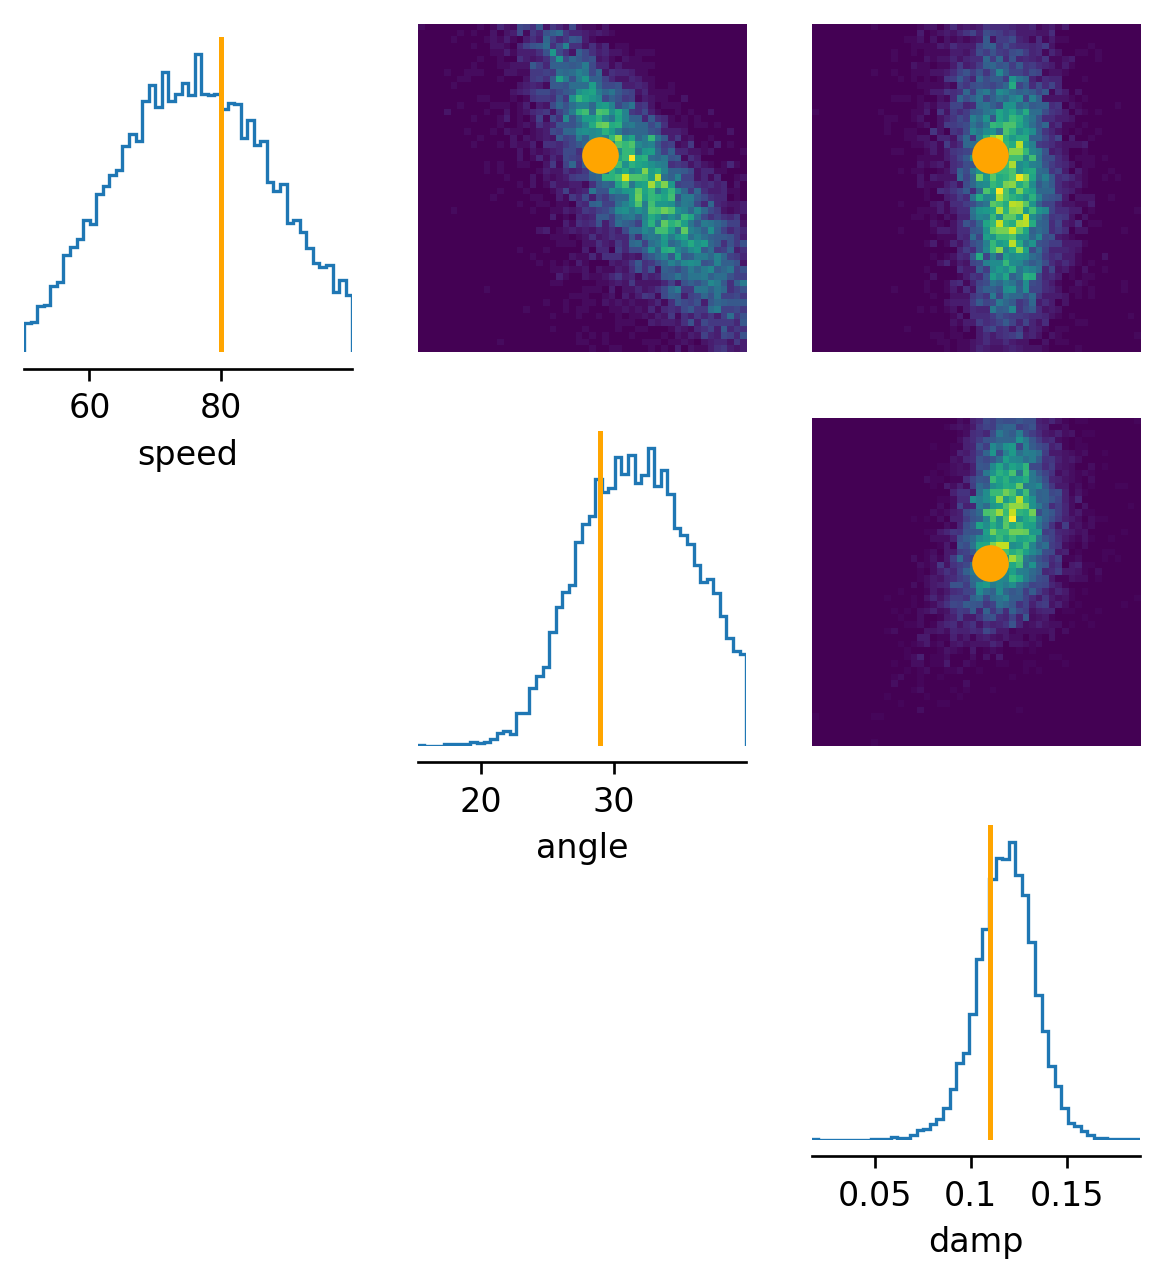

In [17]:
samples = posterior.sample((10000,), x=x_o)
θ = samples.mean(dim=0).numpy()
log_probability = posterior.log_prob(samples, x=x_o)
_ = analysis.pairplot(samples, figsize=(6,6), labels=['speed', 'angle', 'damp'], 
                      points=[(80,29,0.11),], points_colors=('orange',) )

# Summary statistics

You can try and reduce the mortar output to significant observations such as the landing distance, the maximum altitude or the impact angle. You should be able to observe that more data helps constrain the posterior.

Below you find a suggested implementation (by Stefan) of these potential summary statistics. An elegant way to get them, and it should be faster too, is to directly use the `solve_ivp` event facility. This is explained here: https://scipython.com/book2/chapter-8-scipy/examples/a-projectile-with-air-resistance/

Check it out and share your results!

In [18]:
def get_landing_distance(d, x_o):
    """ Compute distance travelled until projectile hits the ground.
    Args:
        d (array): distance travelled by projectile
        x_o (array): height of projectile at given distance
    Returns:
        Distance traveled in meter until projectile hits ground.
    """
    height_greater_zero = x_o > 0
    return d[np.argwhere(height_greater_zero == False).min()]
    
    
def get_distance_at_highest_point(d, x_o):
    """ Compute distance travelled until projectile reaches highest point.
    Args:
        d (array): distance travelled by projectile
        x_o (array): height of projectile at given distance
    Returns:
        Distance traveled in meter until projectile reaches highest point of its trajectory.
    """
    return d[x_o.argmax()]

def get_impact_angle(d_highest_point, h_highest_point, d_impact):
    """ Compute impact angle of projectile
    Args:
        d_highest_point (float): distance travelled at highest point
        h_highest_point (float): height at highest point
        d_impact (float): distance travelled at impact point
    Returns:
        Impact angle
    """
    impact_angle_arctan = np.arctan(h_highest_point/ (d_impact-d_highest_point))
    
    return impact_angle_arctan * 180/np.pi
    